In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from utils import compute_total_J
compute_total_J(False)

21.8


12956637.786666665

In [63]:
from Copter.Session import Session
s = Session()
s.run(10)

d:\STUDY\code\ML notebooks\my\copter\Copter\TwoMotorStick.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(logits).numpy()


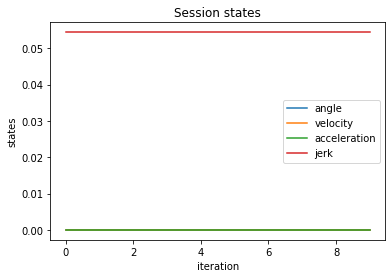

In [64]:
s.plot_states()

In [1]:
# all parameters in mm's and gramms

# STICK_LENGTH = 370.
# STICK_HEIGHT = 59.
# STICK_MASS = 196.

# MOTOR_MASS = 67.
# MOTOR_DISTANCE = 158.
# MOTOR_HEIGHT = 50.

# REGULATOR_MASS = 24.
# REGULATOR_DISTANCE = 70.
# REGULATOR_HEIGHT = 32.

# CENTER_AXIS_IDENT = 17.5
# PILLAR_HEIGH = 0
from model_parameters import *
2 * (MOTOR_MASS * MOTOR_HEIGHT + REGULATOR_MASS * REGULATOR_HEIGHT) \
    / (2 * MOTOR_MASS + 2 * REGULATOR_MASS + STICK_MASS)

21.788359788359788

In [1]:
import torch

In [10]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
c = torch.vstack([a, b])
torch.square(c)

tensor([[ 1,  4,  9],
        [16, 25, 36]])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch


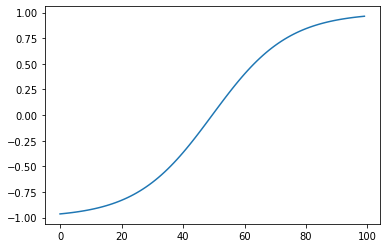

In [22]:
space = np.linspace(-2, 2, 100)
ans = []
for a in space:
    ans.append(torch.tanh(torch.tensor(a)).item())
plt.plot(ans)

In [44]:
import math
mean = 1
var = 1

In [45]:
np.random.normal(mean, var)

1.3196001152839887

In [46]:
a = np.array([1, 3])
a.tolist()

[1, 3]